## GATConv  - Parallel

In [1]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
import sys
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.fftpack import fft, ifft
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
sys.path.append('/mnt/e/eVTOL_model/eVTOL-VehicleModel/src')


# Import necessary functions
from utility_functions import downsample_to_35
from utility_functions import organize_data

# Import all the models
from af_escnn_cl import ESCNN_Cl
from af_escnn_cd import ESCNN_Cd

from af_rbf_cl import RBFLayer_cl, RBFNet_cl
from af_rbf_cd import RBFLayer_cd, RBFNet_cd

### Initialize Airfoil Models

In [4]:
# Initialize airfoil models
root_airfoilModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/airfoil/'
# root_scalers = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/'

# Load the model weights
af_model_ESCNN_Cl = ESCNN_Cl()
af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cl_ESCNN_lr1e-05_e1500_rbf170_convL4.pth'))
af_model_ESCNN_Cl = af_model_ESCNN_Cl.to(device)
af_model_ESCNN_Cl.eval()

# Load the model weights
af_model_ESCNN_Cd = ESCNN_Cd()
af_model_ESCNN_Cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model_Cd_ESCNN_lr5e-05_e250_convL3.pth'))
af_model_ESCNN_Cd = af_model_ESCNN_Cd.to(device)
af_model_ESCNN_Cd.eval()

input_size = 140
output_size = 4
num_rbf_units = 4

kmeans_center_cl = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4_RBFcenters.pth')
kmeans_center_cd = torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4_RBFcenters.pth')


class airfoilModel_cl(RBFNet_cl):
    def __init__(self):
        super(airfoilModel_cl, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cl)


class airfoilModel_cd(RBFNet_cd):
    def __init__(self):
        super(airfoilModel_cd, self).__init__(input_size, num_rbf_units, output_size, kmeans_center_cd)


# Initialize the model
airfoil_cl = airfoilModel_cl()
airfoil_cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cl_ESCNN_RBF_lr0.06_epoch200_rbfUnits4.pth'))

airfoil_cd = airfoilModel_cd()
airfoil_cd.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-19_airfoil_model_Cd_ESCNN_RBF_lr0.025_epoch100_rbfUnits4.pth'))

airfoil_cl = airfoil_cl.to(device)
airfoil_cd = airfoil_cd.to(device)

airfoil_cl.eval()
airfoil_cd.eval()



/tmp/ipykernel_25748/829076333.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  af_model_ESCNN_Cl.load_state_dict(torch.load(root_airfoilModelsTrained + '2024-11-18_model

airfoilModel_cd(
  (rbf): RBFLayer_cd()
  (fc): Linear(in_features=4, out_features=4, bias=True)
)

## Load Wing Data

In [5]:
from create_wing_dataset import WingDataset, subdir_condition_wing   # Make sure to reload the create wing dataset module manually after changes

# root_dir_wing = '/mnt/e/Course_Materials/ROM/wing_model/FLOWUnsteady_simulations/eMO_dataset_train'
root_dir_wing = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/training_data'

# Canard dataset
dataset_canard = WingDataset(root_dir_wing, 
                                af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                airfoil_cl=airfoil_cl, 
                                airfoil_cd=airfoil_cd, 
                                device=device,
                                wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                subdir_condition=subdir_condition_wing)

inputs_canard, outputs_canard = dataset_canard[0:]

input_tensor_canard = inputs_canard
input_tensor_canard = inputs_canard.squeeze(1)  # Reshaping
print("Input shape (Canard dataset):", input_tensor_canard.shape)

output_tensor_canard = outputs_canard.squeeze(1)
print("Output shape (Canard dataset):",output_tensor_canard.shape) 

# Wing dataset
dataset_wing = WingDataset(root_dir_wing, 
                            af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                            af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                            airfoil_cl=airfoil_cl, 
                            airfoil_cd=airfoil_cd, 
                            device=device,
                            wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                            subdir_condition=subdir_condition_wing)

inputs_wing, outputs_wing = dataset_wing[0:]

input_tensor_wing = inputs_wing
input_tensor_wing = inputs_wing.squeeze(1)  # Reshaping
print("Input shape (Wing dataset):", input_tensor_wing.shape)

output_tensor_wing = outputs_wing.squeeze(1)
print("Output shape (Wing dataset):",output_tensor_wing.shape) 




create_wing_dataset module loaded


/mnt/e/eVTOL_model/eVTOL-VehicleModel/src/create_wing_dataset.py:376: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)


Input shape (Canard dataset): torch.Size([39, 277, 10])
Output shape (Canard dataset): torch.Size([39, 277, 2])
Input shape (Wing dataset): torch.Size([39, 277, 10])
Output shape (Wing dataset): torch.Size([39, 277, 2])


In [6]:
input_tensor_all_wing = torch.cat((input_tensor_canard, input_tensor_wing), dim=0)
output_tensor_all_wing = torch.cat((output_tensor_canard, output_tensor_wing), dim=0)

print("Input shape (All wing dataset):", input_tensor_all_wing.shape)
print("Output shape (All wing dataset):",output_tensor_all_wing.shape)

Input shape (All wing dataset): torch.Size([78, 277, 10])
Output shape (All wing dataset): torch.Size([78, 277, 2])


## Load Wing Model and Initialize

In [7]:
from wing_static_attention import LSTMNetWithAttention

# Static Model
input_size_wing_stat = 10           # Number of input features
hidden_size_wing_stat = 50          # Hidden LSTM cells
output_size_wing_stat = 2           # Number of output features
num_layers_wing_stat = 2            # Number of LSTM layers

class WingModel_static(LSTMNetWithAttention):
    def __init__(self):
        super(WingModel_static, self).__init__(input_size_wing_stat, hidden_size_wing_stat, output_size_wing_stat, num_layers_wing_stat)

# Initialize the model

root_wingModelsTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/models/wing/'
root_wingScalersTrained = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/trained_models/scalers/wing/'


wing_model_static = WingModel_static()
# wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2024-11-19_LSTM_eMO_wingModel_static_lr0.002_e1200_nL3_numNN50.pth'))
wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2025-01-09_LSTM_eMO_wingModel_static_lr0.001_e2000_nL2_numNN50.pth'))
wing_model_static = wing_model_static.to(device)
# wing_model_static.eval()

# Load the scaler
# input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_ipScaler_lr0.002_e1200_nL3_numNN50.pkl')
# output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2024-11-19_LSTM_eMO_wingModel_static_opScaler_lr0.002_e1200_nL3_numNN50.pkl')

input_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2025-01-09_LSTM_eMO_wingModel_static_ipScaler_lr0.001_e2000_nL2_numNN50.pkl')
output_scaler_wing_stat = joblib.load(root_wingScalersTrained+'2025-01-09_LSTM_eMO_wingModel_static_opScaler_lr0.001_e2000_nL2_numNN50.pkl')

/tmp/ipykernel_25748/609571991.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  wing_model_static.load_state_dict(torch.load(root_wingModelsTrained+'2025-01-09_LSTM_eMO_

In [8]:
# Creates training and validation datasets
class SimulationDataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return torch.tensor(self.inputs[idx], dtype=torch.float32), torch.tensor(self.outputs[idx], dtype=torch.float32)

In [9]:
# Reshape data for scaling (flatten along the time dimension)
inputs_reshaped = input_tensor_all_wing.reshape(-1, input_size_wing_stat)
outputs_reshaped = output_tensor_all_wing.reshape(-1, output_size_wing_stat)

# Fit and transform inputs and outputs
inputs_all_wing_normalized = input_scaler_wing_stat.transform(inputs_reshaped).reshape(input_tensor_all_wing.shape)
outputs_all_wing_normalized = output_scaler_wing_stat.transform(outputs_reshaped).reshape(output_tensor_all_wing.shape)

print("Normalized input shape:", inputs_all_wing_normalized.shape)
print("Normalized output shape:", outputs_all_wing_normalized.shape)

Normalized input shape: (78, 277, 10)
Normalized output shape: (78, 277, 2)


In [10]:
# Constants
EPOCHS = 1500
BATCH_SIZE = 2
LEARNING_RATE = 1e-3

In [11]:
val_percentage = 0.3   # Percentage of data to be used for testing

train_dataset_num = len(input_tensor_all_wing) - int(len(input_tensor_all_wing)*val_percentage)    
print("Number of datasets to be used for training:", train_dataset_num)
print("Number of datasets to be used for evaluation:", len(input_tensor_all_wing) - train_dataset_num)

# Create the normalized dataset using the custom Dataset class
train_dataset = SimulationDataset(inputs_all_wing_normalized[:train_dataset_num], outputs_all_wing_normalized[:train_dataset_num])    # First 70% for training
val_dataset = SimulationDataset(inputs_all_wing_normalized[train_dataset_num:], outputs_all_wing_normalized[train_dataset_num:])      # Remaining for evaluation

# Create DataLoaders
trainDataLoader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)    # Shuffle training data
valDataLoader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

Number of datasets to be used for training: 55
Number of datasets to be used for evaluation: 23


In [12]:

# Ensure all parameters are trainable (for fine-tuning)
for param in wing_model_static.parameters():
    param.requires_grad = True


In [13]:
# # Optimizer for fine-tuning pre-trained models
# fine_tune_params_wing = list(pretrained_wing.fc2.parameters())
# fine_tune_params_rotor = list(pretrained_rotor1.fc.parameters()) + \
#                             list(pretrained_rotor2.fc.parameters())

# # optimizer_fine_tune_wing = torch.optim.Adam(fine_tune_params_wing, lr=2e-3)
# optimizer_fine_tune_rotor = torch.optim.Adam(fine_tune_params_rotor, lr=5e-3)

In [14]:
def custom_loss(pred, target):
    return torch.mean((pred - target) ** 2) + 0.8 * torch.mean(torch.abs(pred - target))

In [15]:
# criterion = nn.MSELoss()
criterion = custom_loss
optimizer_fine_tune_wing = torch.optim.Adam(wing_model_static.parameters(), lr=LEARNING_RATE)

In [16]:
train_losses = []
eval_losses = []

print("[INFO] training the network...")

# Training loop
for epoch in range(EPOCHS):
    wing_model_static.train()
    running_loss = 0.0
    
    for inputs, targets in trainDataLoader:
        inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)

        # Forward pass
        outputs = wing_model_static(inputs)
        
        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer_fine_tune_wing.zero_grad()
        loss.backward()
        optimizer_fine_tune_wing.step()
        
        running_loss += loss.item()

    avg_train_loss = running_loss / len(trainDataLoader)
    train_losses.append(avg_train_loss)


    # Evaluation Loop
    wing_model_static.eval()
    eval_loss = 0.0

    with torch.no_grad():
        for inputs, targets in valDataLoader:
            inputs, targets = inputs.squeeze(1).to(device), targets.squeeze(1).to(device)
            
            # Forward pass
            outputs = wing_model_static(inputs)
            # outputs, attention_weights = model(inputs)

            loss = criterion(outputs, targets)
            eval_loss += loss.item()

        avg_eval_loss = eval_loss / len(valDataLoader)
        eval_losses.append(avg_eval_loss)
    
    print(f'Epoch [{epoch+1}/{EPOCHS}],\n Training Loss: {running_loss/len(trainDataLoader):.8f}')
    print(f'Evaluation Loss: {eval_loss/len(valDataLoader):.8f}')


print("[INFO] Finished training the network...")

[INFO] training the network...
Epoch [1/1500],
 Training Loss: 0.34670454
Evaluation Loss: 0.18300611
Epoch [2/1500],
 Training Loss: 0.32659463
Evaluation Loss: 0.19512555
Epoch [3/1500],
 Training Loss: 0.32613958
Evaluation Loss: 0.18603134
Epoch [4/1500],
 Training Loss: 0.31463295
Evaluation Loss: 0.18213453
Epoch [5/1500],
 Training Loss: 0.30789683
Evaluation Loss: 0.18782383
Epoch [6/1500],
 Training Loss: 0.26572570
Evaluation Loss: 0.17426799
Epoch [7/1500],
 Training Loss: 0.23823421
Evaluation Loss: 0.19689347
Epoch [8/1500],
 Training Loss: 0.23106622
Evaluation Loss: 0.17971327
Epoch [9/1500],
 Training Loss: 0.22414517
Evaluation Loss: 0.15812011
Epoch [10/1500],
 Training Loss: 0.22781225
Evaluation Loss: 0.15842294
Epoch [11/1500],
 Training Loss: 0.23134499
Evaluation Loss: 0.21921159
Epoch [12/1500],
 Training Loss: 0.22167206
Evaluation Loss: 0.20403942
Epoch [13/1500],
 Training Loss: 0.27254641
Evaluation Loss: 0.13467229
Epoch [14/1500],
 Training Loss: 0.2257163

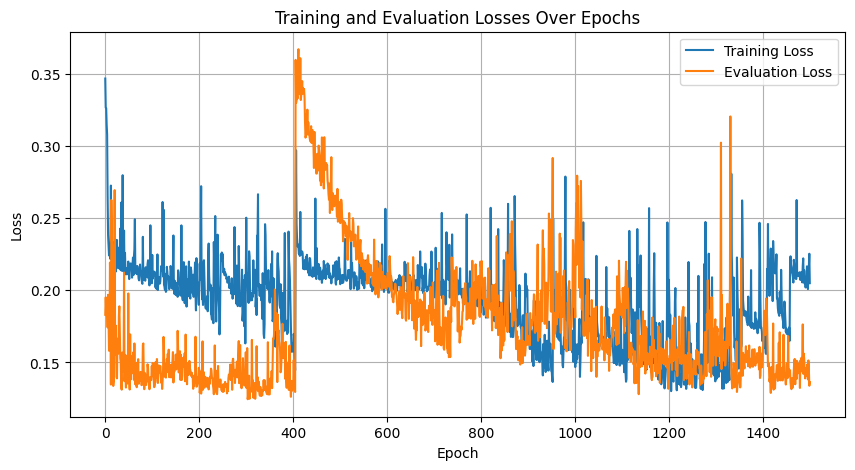

In [17]:
# Plotting the training and evaluation losses
plt.figure(figsize=(10, 5))
plt.plot((train_losses), label='Training Loss')
plt.plot((eval_losses), label='Evaluation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Test the model

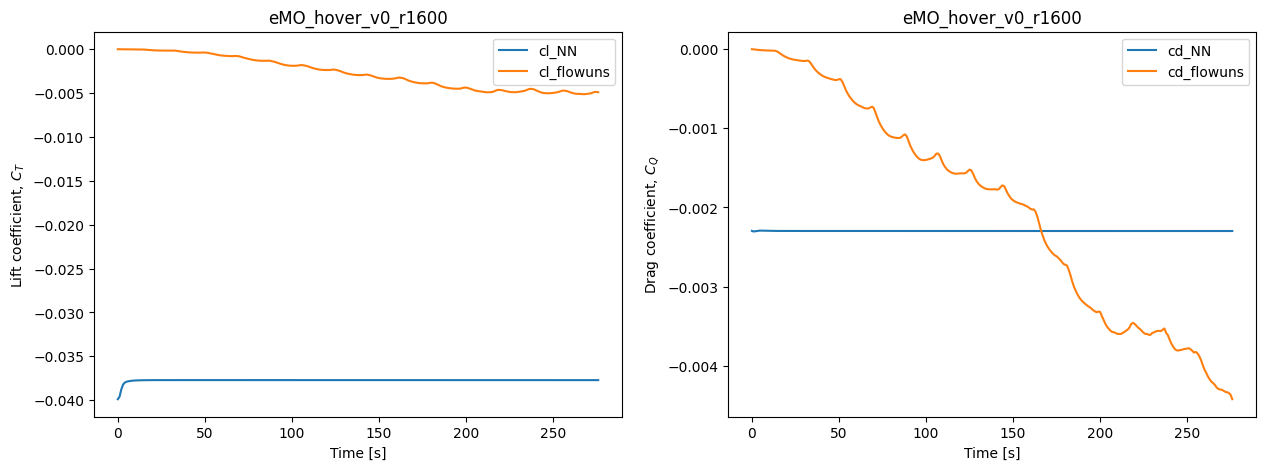

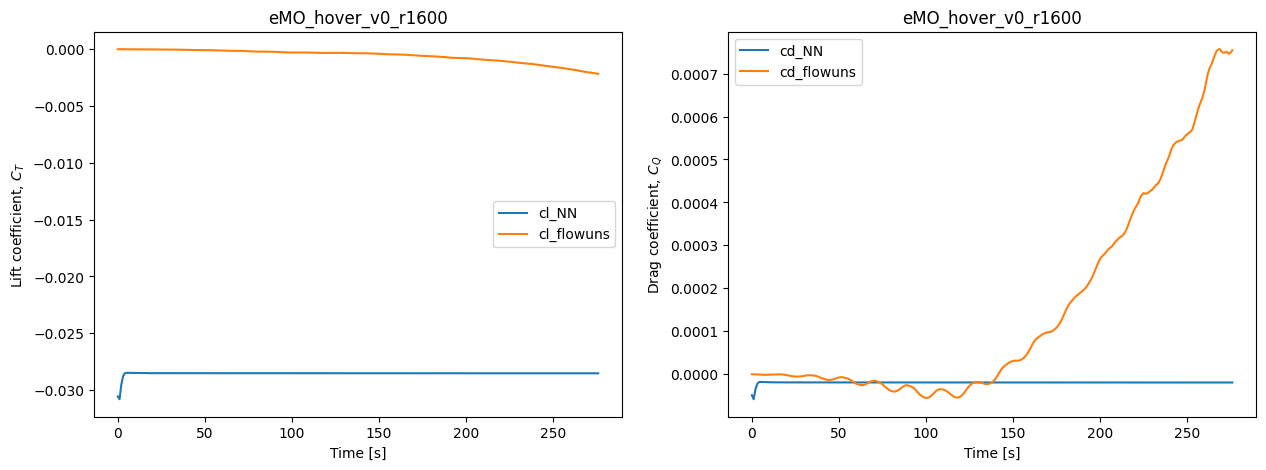

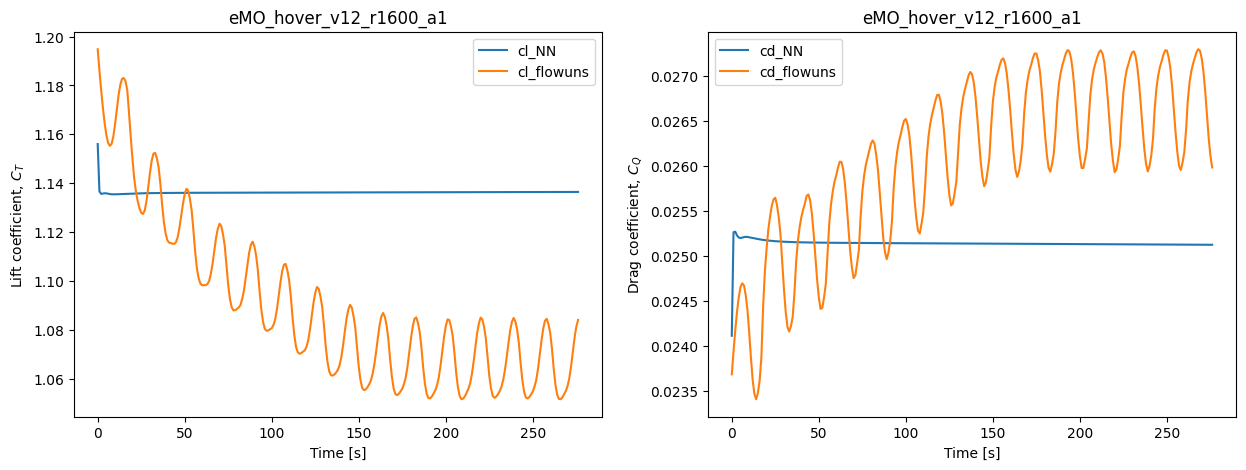

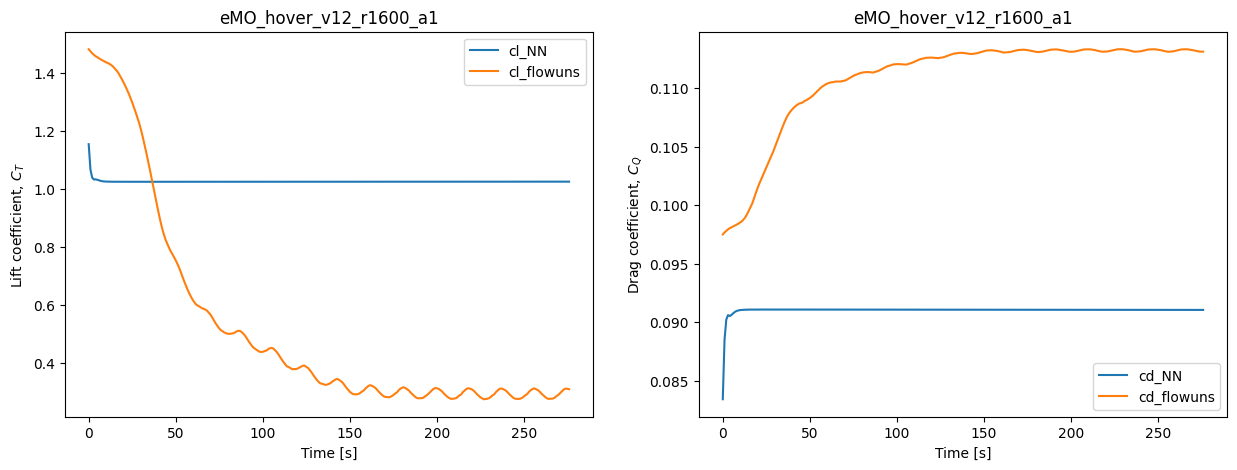

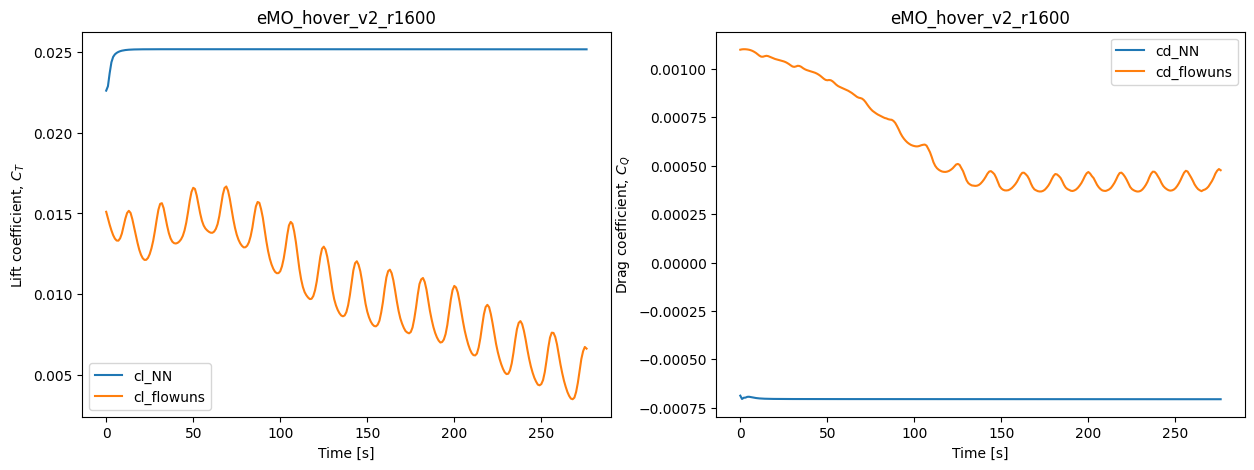

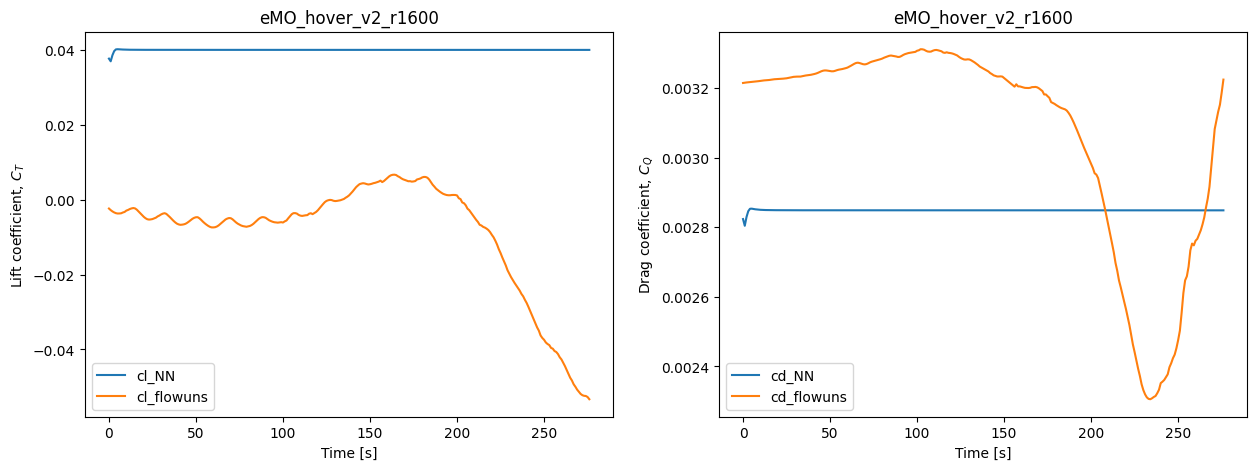

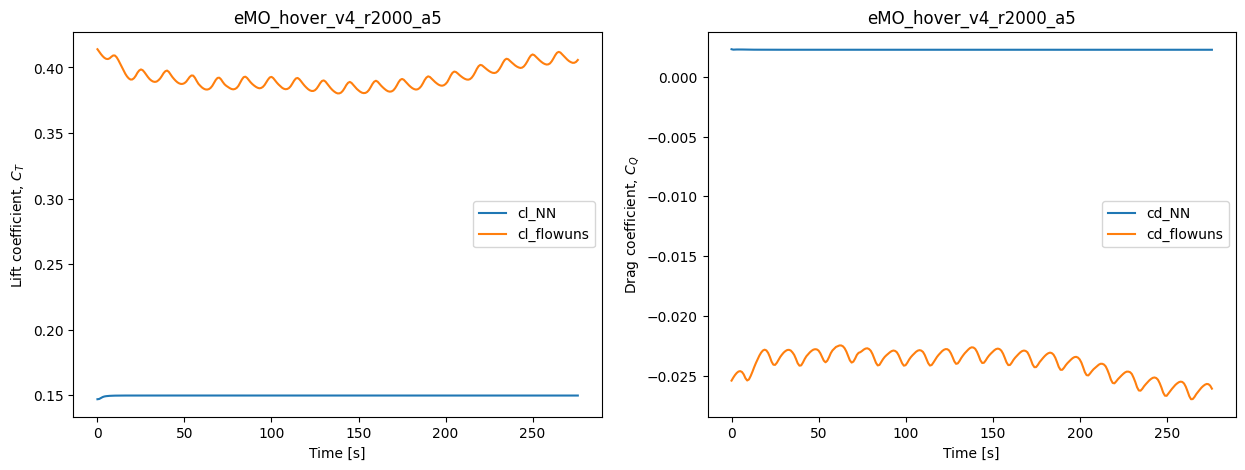

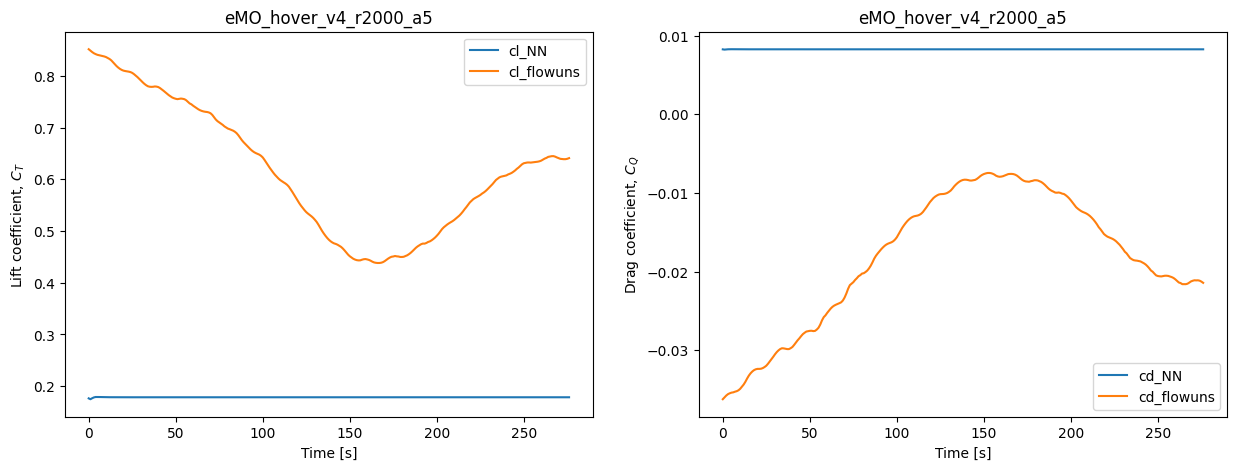

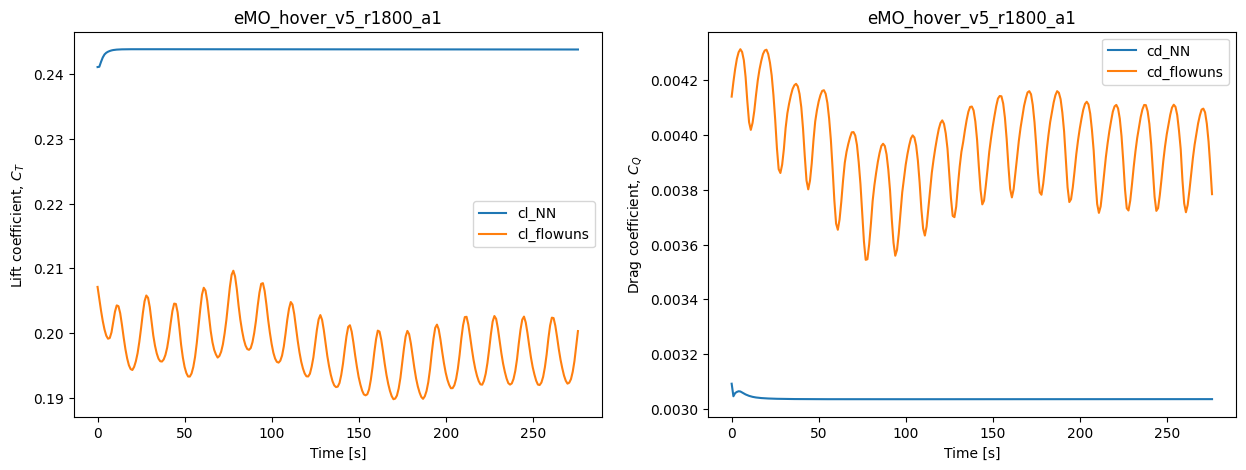

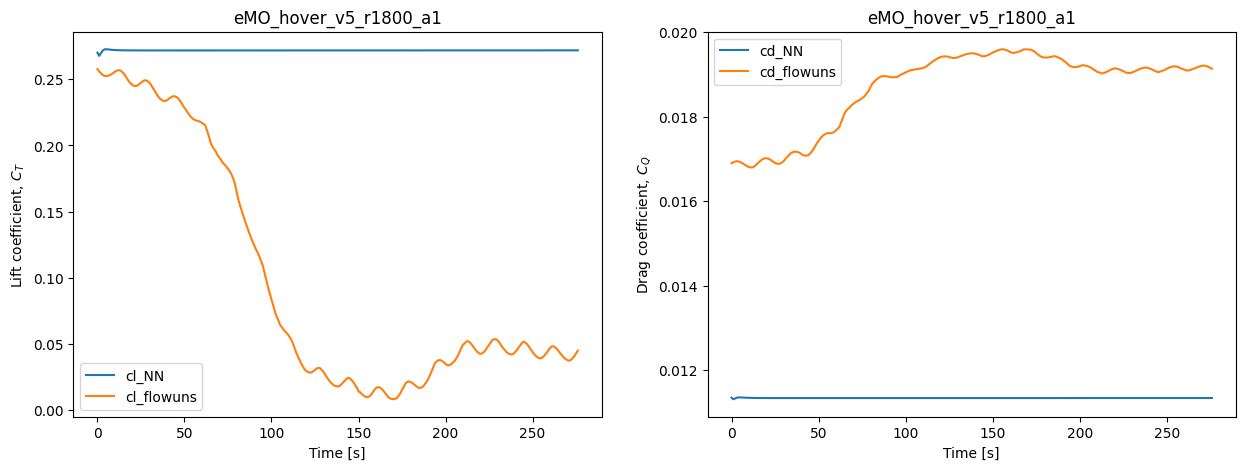

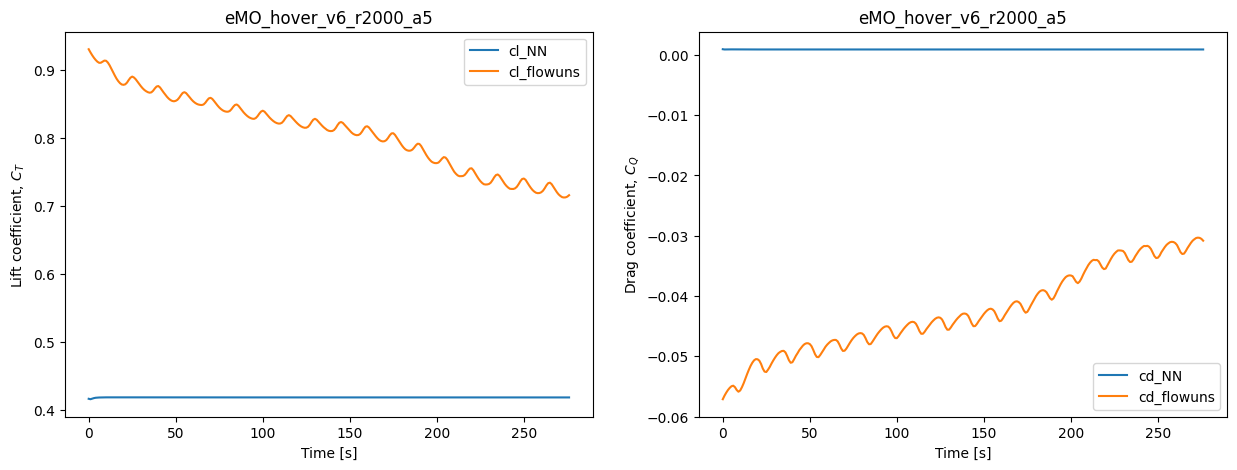

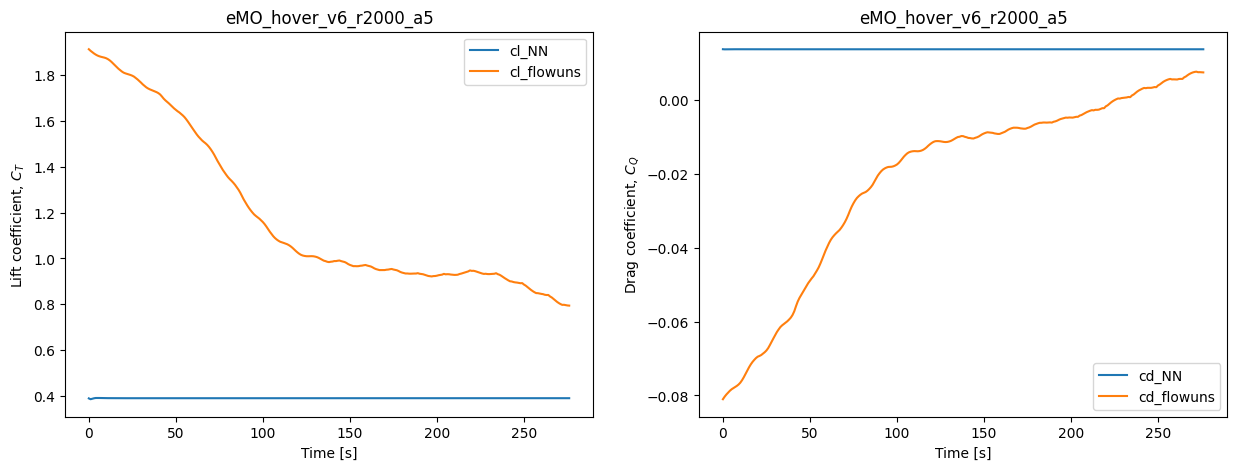

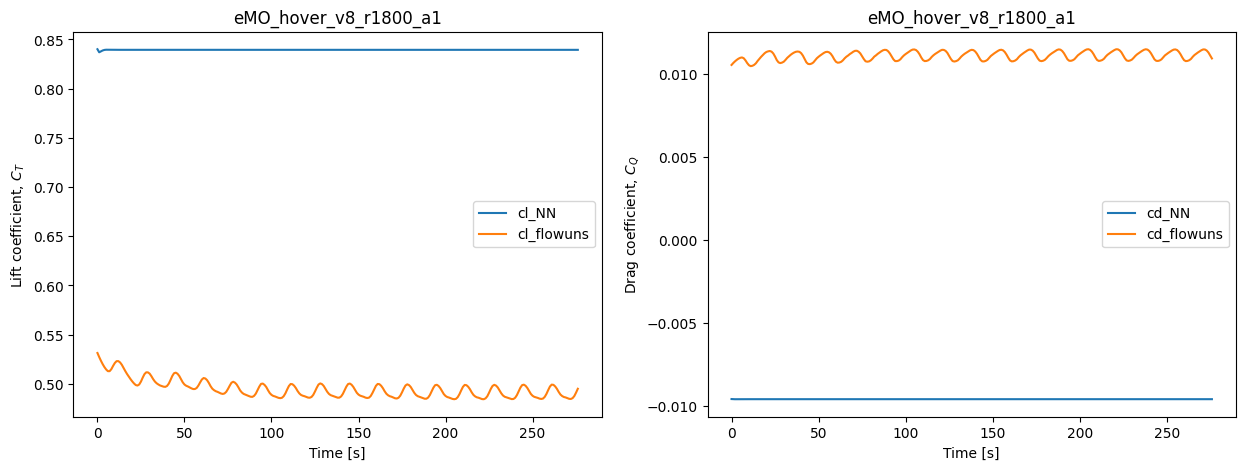

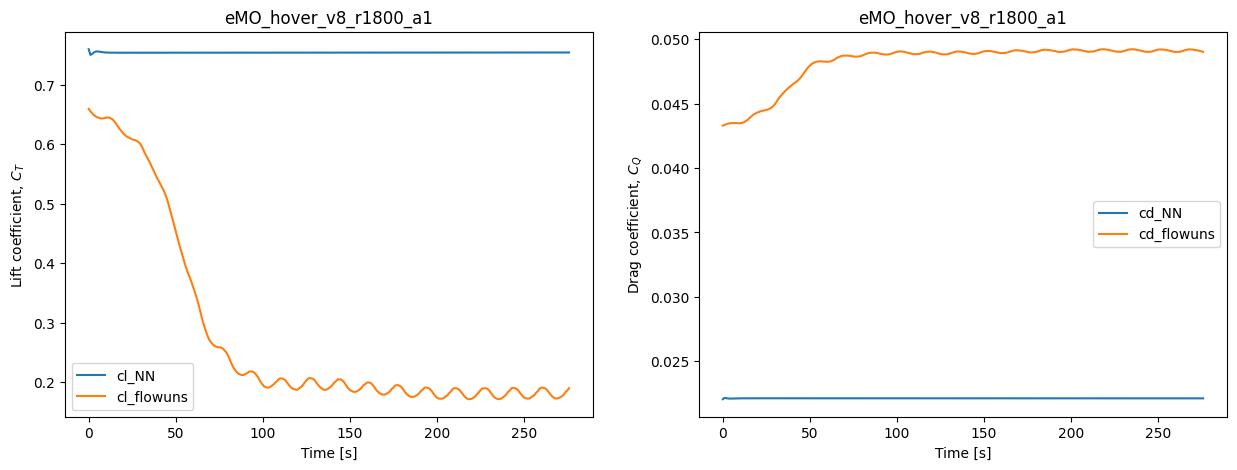

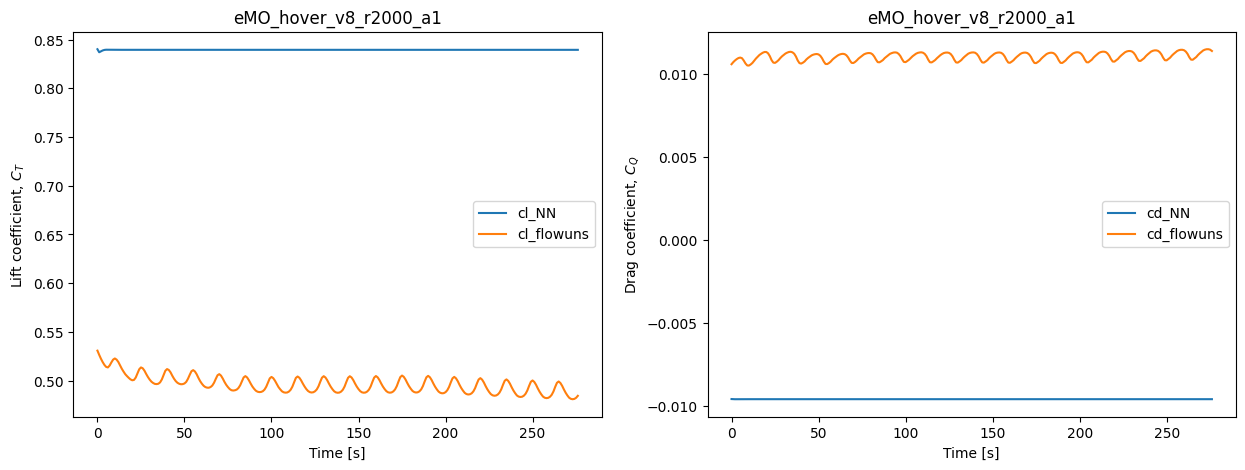

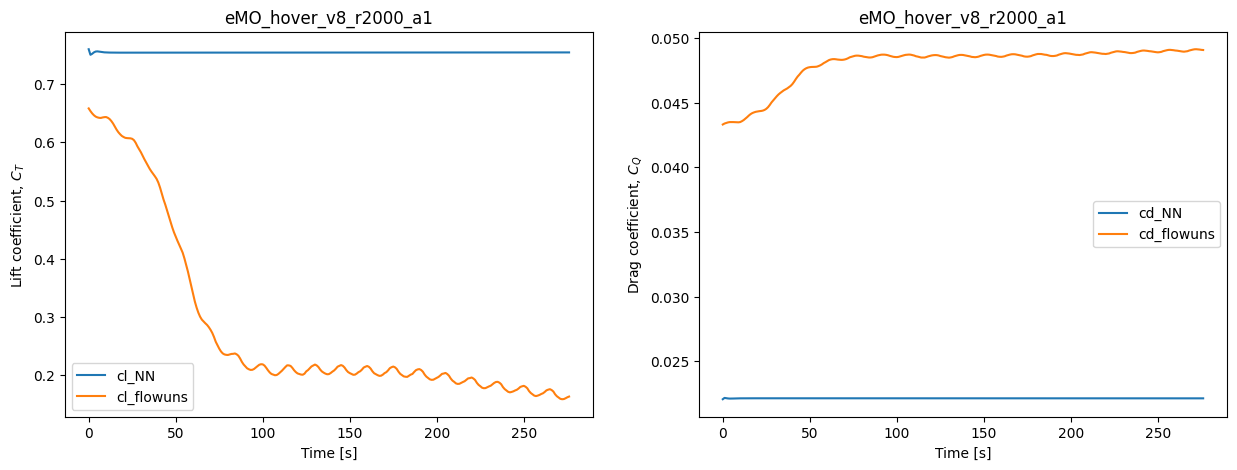

In [18]:
 
from sklearn.metrics import mean_squared_error 

root_test_base = '/mnt/e/eVTOL_model/eVTOL-VehicleModel/FLOWUnsteady_simulations/aircraft_data/testing_data/'
batch_size_test = 1

for simulation_case in os.listdir(root_test_base):

    root_test_dir = root_test_base+simulation_case

    # Canard dataset
    dataset_canard_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'Canard',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_canard_test, outputs_canard_test = dataset_canard_test[0:]

    input_tensor_canard_test = inputs_canard_test
    input_tensor_canard_test = inputs_canard_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_canard_test = outputs_canard_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape)
     
    # Wing dataset
    dataset_wing_test = WingDataset(root_test_dir, 
                                    af_model_ESCNN_Cl=af_model_ESCNN_Cl, 
                                    af_model_ESCNN_Cd=af_model_ESCNN_Cd,
                                    airfoil_cl=airfoil_cl, 
                                    airfoil_cd=airfoil_cd, 
                                    device=device,
                                    wing_name = 'wing_main',     # select 'wing_main' or 'Canard'  
                                    subdir_condition=subdir_condition_wing)

    inputs_wing_test, outputs_wing_test = dataset_wing_test[0:]

    input_tensor_wing_test = inputs_wing_test
    input_tensor_wing_test = inputs_wing_test.squeeze(1)  # Reshaping
    # print("Input shape (Canard dataset):", input_tensor_canard.shape)
    output_tensor_wing_test = outputs_wing_test.squeeze(1)
    # print("Output shape (Canard dataset):",output_tensor_canard.shape) 


    datasets = [dataset_canard_test, dataset_wing_test]

    for dataset_test in datasets:

        inputs_test, outputs_test = dataset_test[0:]
        input_tensor_test = inputs_test.squeeze(1)
        output_tensor_test = outputs_test.squeeze(1)

        inputs_test_reshaped = input_tensor_test.reshape(-1, input_size_wing_stat)

        test_inputs_normalized = input_scaler_wing_stat.transform(inputs_test_reshaped.reshape(-1, input_size_wing_stat)).reshape(input_tensor_test.shape)

        test_inputs_tensor = torch.tensor(test_inputs_normalized, dtype=torch.float32).to(device)
    

        wing_model_static.eval()  # Set the model to evaluation mode

        with torch.no_grad():
            predicted_outputs = wing_model_static(test_inputs_tensor)

        # Convert the predictions back to numpy and inverse scale the outputs
        predicted_outputs = predicted_outputs.cpu().detach().numpy()  # Convert tensor to numpy array
        predicted_outputs_original_scale = output_scaler_wing_stat.inverse_transform(predicted_outputs.reshape(-1, output_size_wing_stat))

        # Reshape the predictions to match the original sequence structure if needed
        predicted_outputs_original_scale = predicted_outputs_original_scale.reshape(input_tensor_test.shape[0], input_tensor_test.shape[1], output_size_wing_stat)
        predicted_outputs_original_scale = predicted_outputs_original_scale[0]

        cl_test_NN = predicted_outputs_original_scale[:,0]
        cd_test_NN = predicted_outputs_original_scale[:,1]

        # Load timesteps, CT and CQ from FLOWUnsteady simualtions
        time_steps = dataset_test.get_variable('time')

        cl_test_flowuns = dataset_test.get_variable('CL')
        cd_test_flowuns = dataset_test.get_variable('CD')

        # plt.figure()
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        # plt.plot(time_steps[0], ct_test_NN, label = 'ct_NN')
        # plt.plot(time_steps[0], (ct_test_flowuns[0]), label = 'ct_flowuns')
        plt.plot(cl_test_NN, label = 'cl_NN')
        plt.plot((cl_test_flowuns[0]), label = 'cl_flowuns')
        plt.xlabel('Time [s]')
        plt.ylabel('Lift coefficient, $C_T$')
        plt.title(simulation_case)
        plt.legend()

        # plt.figure()
        plt.subplot(1, 2, 2)
        # plt.plot(time_steps[0], cq_test_NN, label = 'cq_NN')
        # plt.plot(time_steps[0], cq_test_flowuns[0], label = 'cq_flowuns')
        plt.plot(cd_test_NN, label = 'cd_NN')
        plt.plot(cd_test_flowuns[0], label = 'cd_flowuns')
        plt.xlabel('Time [s]')
        plt.ylabel('Drag coefficient, $C_Q$')
        plt.title(simulation_case)
        plt.legend()
    

    

    